In [1]:
# loading packages
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
import shap
# Loading our own functions
import Functions as Func
import pandas as pd



In [2]:
# We run the same procedure as in Main to get our XGB model

df = Func.load_and_basic_process()
df_X, df_Y = Func.df_data_process(df)

X_model, X_test, Y_model, Y_test = train_test_split(df_X, df_Y, test_size=0.1, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_model, Y_model, test_size=0.2, random_state=2)

dtrain_reg = xgb.DMatrix(X_model, label=Y_model["Frequency"], weight=Y_model["Exposure"])
dtest_reg = xgb.DMatrix(X_test, label=Y_test["Frequency"], weight=Y_test["Exposure"])

params = {"objective": "count:poisson", "tree_method": "hist"}
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

n = 1000
fit_xgb = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   early_stopping_rounds=10,
)

In [6]:
# Assuming fit_xgb is your trained model and X_model is a DataFrame
import pandas as pd

# Step 1: Generate predictions
dmodel_reg = xgb.DMatrix(X_model)
predictions = fit_xgb.predict(dmodel_reg)

# Step 2: Add predictions as a new column to X_model
X_model_with_predictions = X_model.copy()  # To keep the original DataFrame unchanged
X_model_with_predictions['Frequency_Predictions'] = predictions

combined_df = pd.concat([X_model_with_predictions, Y_model], axis=1)

In [7]:
X_model_with_predictions.head(3)


,VehAge,DrivAge,BonusMalus,Density,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,...,Region_R91,Region_R93,Region_R94,Area_A,Area_B,Area_C,Area_D,Area_E,Area_F,Frequency_Predictions
IDpol,,,,,,,,,,,,,,,,,,,,,
2105219,4,47,50,-0.577716,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.062209
2125855,14,71,85,0.878537,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.148646
1002414,1,28,83,2.268692,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.087131


In [8]:
Y_model.head(3)

,ClaimAmount,PurePremium,Frequency,AvgClaimAmount,Exposure,ClaimNb
IDpol,,,,,,
2105219,0.00,0.000000,0.000000,0.00,0.58,0
2125855,0.00,0.000000,0.000000,0.00,0.83,0
1002414,1700.91,2395.647887,1.408451,1700.91,0.71,1


In [9]:
combined_df.head()

,VehAge,DrivAge,BonusMalus,Density,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,...,Area_D,Area_E,Area_F,Frequency_Predictions,ClaimAmount,PurePremium,Frequency,AvgClaimAmount,Exposure,ClaimNb
IDpol,,,,,,,,,,,,,,,,,,,,,
2105219,4,47,50,-0.577716,0,0,0,0,0,0,...,0,0,0,0.062209,0.00,0.000000,0.000000,0.00,0.58,0
2125855,14,71,85,0.878537,0,0,0,0,0,0,...,0,1,0,0.148646,0.00,0.000000,0.000000,0.00,0.83,0
1002414,1,28,83,2.268692,0,0,0,1,0,0,...,0,0,1,0.087131,1700.91,2395.647887,1.408451,1700.91,0.71,1
1176420,2,41,50,0.640250,0,0,0,0,1,0,...,1,0,0,0.062610,0.00,0.000000,0.000000,0.00,1.00,0
3091339,12,40,50,-1.936414,0,0,0,0,1,0,...,0,0,0,0.035836,0.00,0.000000,0.000000,0.00,1.00,0


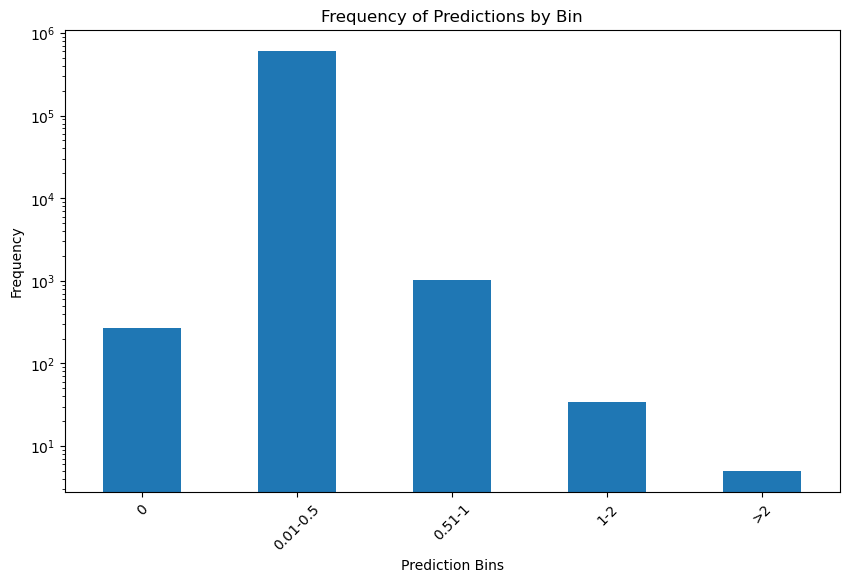

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define bins
bins = [-np.inf, 0.01, 0.5, 1, 2, np.inf]

# Use pd.cut to categorize predictions into bins
combined_df['Prediction_Bins'] = pd.cut(combined_df['Frequency_Predictions'], bins, labels=["0", "0.01-0.5", "0.51-1", "1-2", ">2"])

# Plot histogram
plt.figure(figsize=(10, 6))
ax = combined_df['Prediction_Bins'].value_counts().sort_index().plot(kind='bar')
combined_df['Prediction_Bins'].value_counts().sort_index().plot(kind='bar')
plt.title('Frequency of Predictions by Bin')
plt.xlabel('Prediction Bins')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
ax.set_yscale('log')
plt.show()


In [11]:
# Get raw numbers in each bin
bin_counts = combined_df['Prediction_Bins'].value_counts().sort_index()
print(bin_counts)


0              270
0.01-0.5    608875
0.51-1        1027
1-2             34
>2               5
Name: Prediction_Bins, dtype: int64


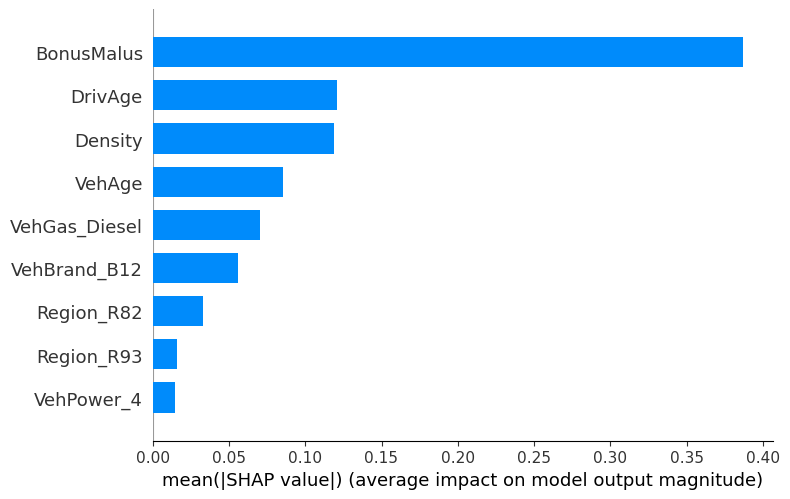

In [12]:
explainer = shap.TreeExplainer(fit_xgb)
shap_values = explainer.shap_values(dtrain_reg)
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display = 9)

100%|===================| 609943/610211 [28:19<00:00]        

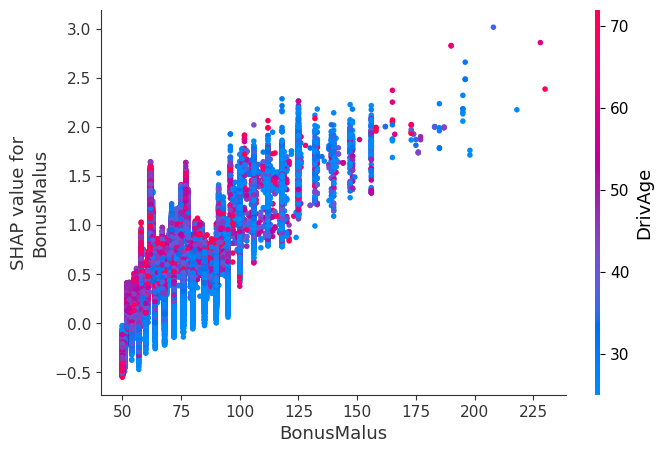

In [14]:
explainer = shap.Explainer(fit_xgb, X_model)
shap_values = explainer(X_model)

# Extract the SHAP values array
shap_values_array = shap_values.values
feature_names = X_model.columns

# This takes the index of the features of interest
feature_index = feature_names.get_loc('BonusMalus')
interaction_index = feature_names.get_loc('DrivAge')

# Plot the SHAP dependence plot for a single feature
shap.dependence_plot(
    feature_index,
    shap_values_array,
    X_model,
    feature_names=feature_names,
    interaction_index=interaction_index
)

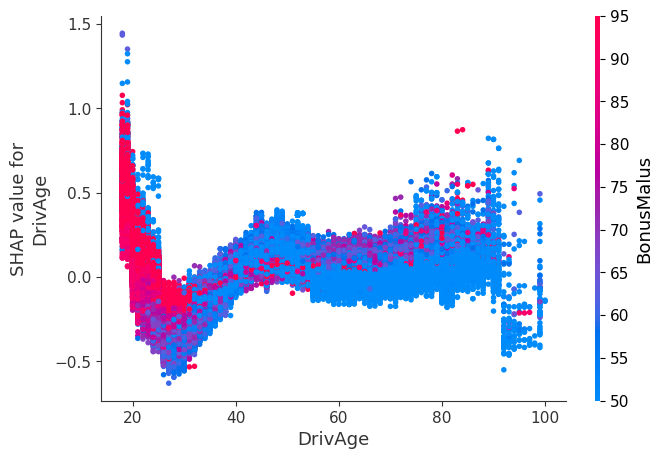

In [19]:
# This takes the index of the features of interest
feature_index = feature_names.get_loc('DrivAge')
interaction_index = feature_names.get_loc('BonusMalus')

shap.dependence_plot(
    feature_index,
    shap_values_array,
    X_model,
    feature_names=feature_names,
    interaction_index=interaction_index
)

100%|===================| 610093/610211 [34:26<00:00]        

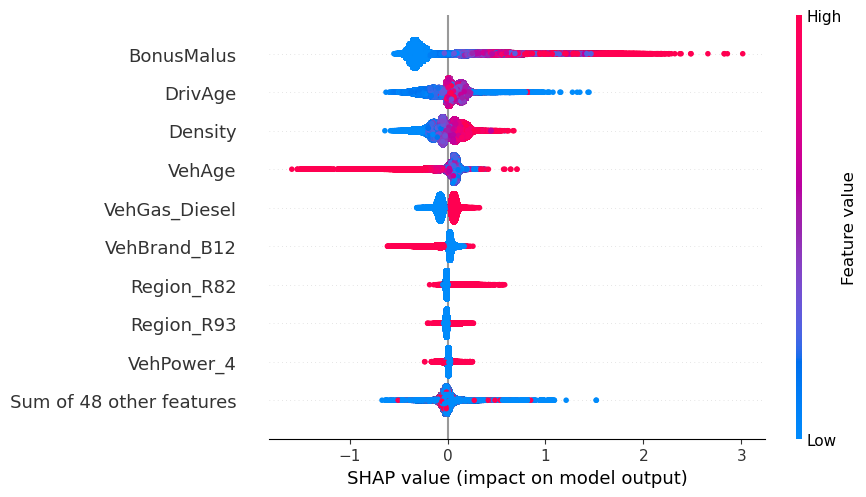

In [15]:
# Base explainer object (not tree)
explainer = shap.Explainer(fit_xgb, X_model)
shap_values = explainer(X_model)
shap.plots.beeswarm(shap_values)

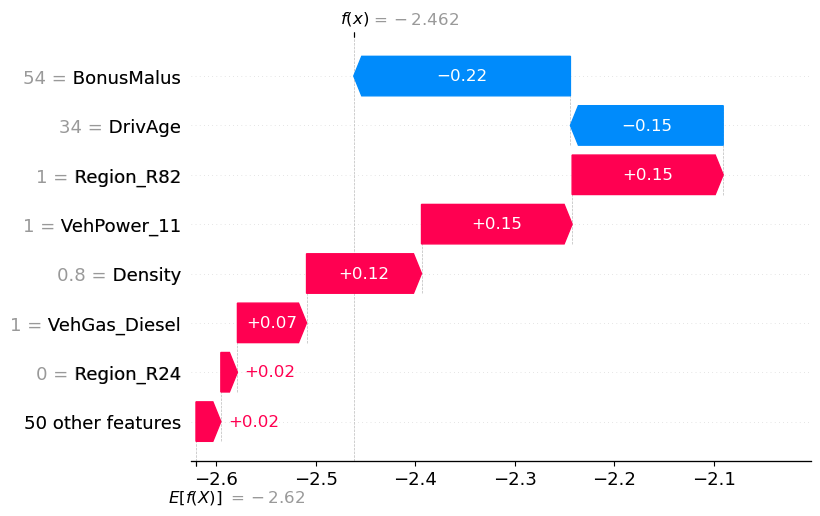

In [21]:
# Tree explainer is neccessary here
explainer = shap.TreeExplainer(fit_xgb)
shap_values = explainer.shap_values(X_model)

idx = 50

# The Poisson model outputs don't generally need scaling like the MAE version
scaled_shap_values = shap_values * 1

# Creating an Explanation object with scaled values
expl_scaled = shap.Explanation(values=scaled_shap_values[idx],
                               base_values=explainer.expected_value * 1,  
                               data=X_model.iloc[idx],
                               feature_names=X_model.columns.tolist())


import matplotlib.pyplot as plt


shap.plots.waterfall(expl_scaled, max_display=8)

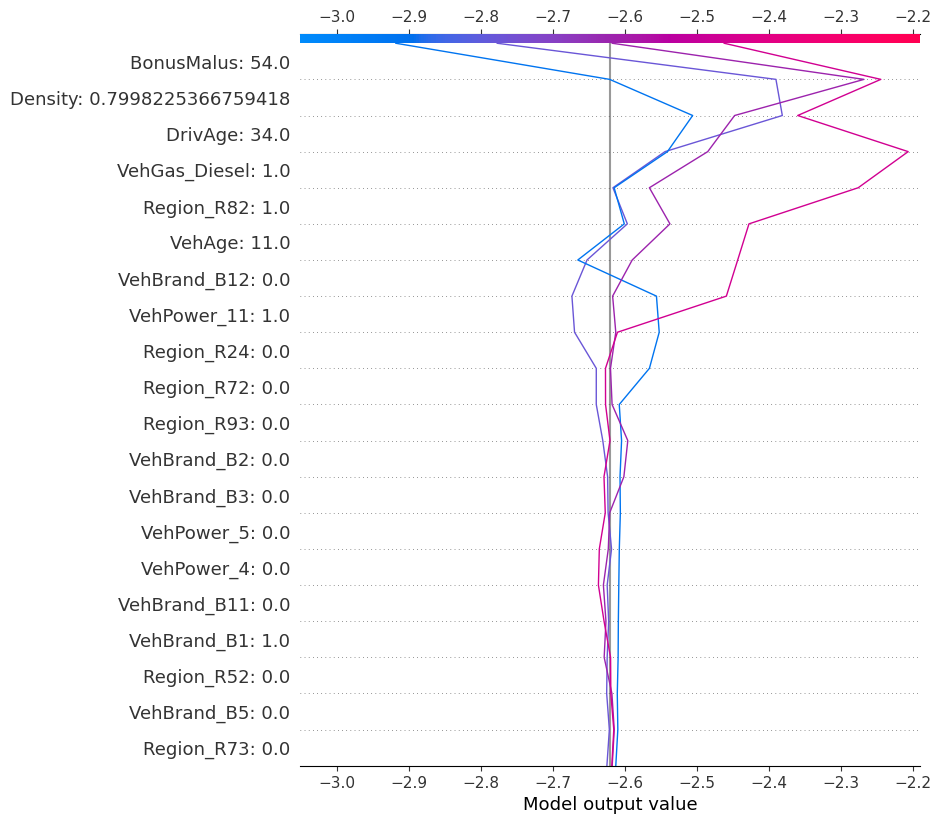

In [20]:
show_idx = [0, 30, 31, 50]

# Scaling factor
scaled_shap_values_subset = shap_values[show_idx] * 1
scaled_expected_value = explainer.expected_value * 1

feature_display_names = [f"{feature}: {X_model.iloc[idx][feature]}" for feature in X_model.columns]

shap.decision_plot(
    base_value=scaled_expected_value,
    shap_values=scaled_shap_values_subset,
    features=X_model.iloc[show_idx],
    feature_names=feature_display_names,
    link='identity',  
    legend_location="upper center"  
)


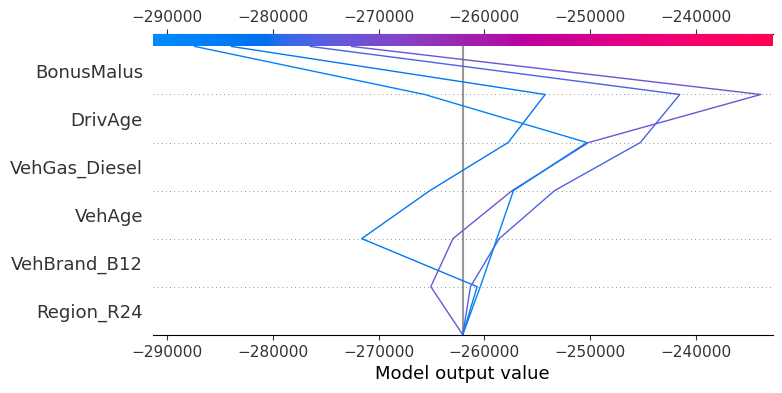

In [18]:
show_idx = [0, 30, 31, 50]  # Indices of instances to show
top_n_features = 6


top_features_indices = np.argsort(np.abs(scaled_shap_values_subset[0]), axis=0)[-top_n_features:]

filtered_shap_values_subset = scaled_shap_values_subset[:, top_features_indices]
filtered_features = X_model.iloc[show_idx, top_features_indices]

filtered_feature_display_names = [X_model.columns[feature_idx] for feature_idx in top_features_indices]

shap.decision_plot(
    base_value=scaled_expected_value,
    shap_values=filtered_shap_values_subset,
    features=filtered_features,
    feature_names=filtered_feature_display_names,
    link='identity',
    legend_location="upper center"
)
